In [1]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
HT_PATH = '/content/drive/MyDrive/Hackaton BBVA'
VR_PATH = '/content/drive/MyDrive/Reto Vinculación rentable'

In [3]:
# 1_SOCIODEMOGRAFICOS | 2_ADICIONAL | 3_TENENCIA_PRODUCTOS | 4_RENTABILIDAD_CIENTE
# 5_RENTABILIDAD_PRODUCTO | 6_MOVIMIENTO_TARJETA | 7_DEUDA_SSFF

tablas={}
for i in range(1,8):
  base = '/base 0'+str(i)+'_V3.csv'
  try:
    tablas[i] = pd.read_csv(VR_PATH+base, sep = '|')
  except:
    tablas[i] = pd.read_csv(VR_PATH+'/base 07_V3 (1).csv', sep = '|')

#Librerías

In [ ]:
!pip install geopandas
!pip install alphashape
!pip install kneed
!pip install unidecode

In [ ]:
#Algoritmos de clasificación
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans

from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from geopy.distance import geodesic 

from scipy.spatial import distance_matrix
import mpl_toolkits

# from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
from branca.element import Template, MacroElement

# De ley
import numpy as np
import pandas as pd
import random
import math
import collections
import time 
import unidecode

#Mapas
import alphashape
import folium
import geopandas as gpd
from geopy.distance import geodesic

from shapely.geometry import Polygon
from folium.plugins import MarkerCluster
from urllib.parse import urlencode, urlparse, parse_qsl
import requests
from itertools import chain
from kneed import DataGenerator, KneeLocator

import itertools
import warnings
warnings.filterwarnings("ignore")

# Lectura

In [ ]:
##Tabla Dummie, SUPONGO QUE TODAS son personas físicas
t_dumm = tablas[i]

In [ ]:
t_dumm.head(1)

# Funciones

In [ ]:
def dat_activo(dat):
  cond_int = dat.att.reset_index()
  cond_int.columns = ['index',0]
  cond_int['index'] = range(1,len(cond_int)+1)
  cond_act = cond_int['index']>=min(cond_int[cond_int[0]==0]['index'])
  cond_act.index = dat.index
  dat_periodo_activo = dat[cond_act]
  dat_periodo_inactivo = dat[~cond_act]
  return dat_periodo_activo, dat_periodo_inactivo

def fix_code(x,l=5):
    x = str(x)
    x = x.replace('.0','')
    while len(x) < l:
        x = '0'+x
    return x

def p90(x):
  return np.percentile(x,q=[90])[0]

def p75(x):
  return np.percentile(x,q=[75])[0]

def p25(x):
  return np.percentile(x,q=[25])[0]

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

# Obtener los periodos de inactividad y su duración
def periodos_inact_1(condicion):
  cond_int = condicion.astype(int).reset_index()
  cond_int.columns = ['index',0]
  cond_int['index'] = range(1,len(cond_int)+1)
  if cond_int[0][len(cond_int)-1] == 1:
    cond_int = pd.concat([cond_int,pd.DataFrame({'index':[len(cond_int)+1],0:[0]})])
  cond_int['cs'] = np.cumsum(cond_int[0])
  cond_int['t_1'] = cond_int[0].shift(1)
  cond_int = cond_int.fillna(0)

  cond_int['diff'] = cond_int['t_1']-cond_int[0]

  cond_ = cond_int[cond_int['diff']>0]
  cond_['saltos'] = cond_['cs']-cond_['cs'].shift(1).fillna(0)
  cond_ = cond_[['index','saltos']]
  cond_.columns = ['periodo','saltos']
  return cond_



def periodos_inact(condicion):
  cond_int = condicion.astype(int).reset_index()
  cond_int.columns = ['index',0]
  cond_int['index'] = range(1,len(cond_int)+1)

  # Quitar las partes iniciales sin actividad
  cond_int = cond_int[cond_int['index']>=min(cond_int[cond_int[0]==0]['index'])]
  cond_int['index_2'] = range(1,len(cond_int)+1)

  ul_per_inac = cond_int[0].iloc[len(cond_int)-1] == 1
  
  if ul_per_inac:
    cond_int = pd.concat([cond_int,pd.DataFrame({'index':[len(cond_int)+1],0:[0]})])
  cond_int['cs'] = np.cumsum(cond_int[0])
  cond_int['t_1'] = cond_int[0].shift(1)
  cond_int = cond_int.fillna(0)

  cond_int['diff'] = cond_int['t_1']-cond_int[0]

  cond_ = cond_int[cond_int['diff']>0]
  cond_['saltos'] = cond_['cs']-cond_['cs'].shift(1).fillna(0)
  cond_['abandono_vigente'] = 0

  if ul_per_inac & len(cond_)==1:
    cond_['abandono_vigente'] = 1
  cond_ = cond_[['index','index_2','saltos','abandono_vigente']]
  cond_.columns = ['periodo','periodo_orig','saltos','abandono_vigente']

  return cond_

In [ ]:
def es_nan(las):
  return any([np.isnan(x) for x in las])*1

# Tratamiento

In [ ]:
# t_dumm[(t_dumm['CODIGO_CLIENTE']==6087553)&(t_dumm['DIVISA']==2)]

In [ ]:
id_cols = ['CODIGO_CLIENTE','TIPO_DOCUMENTO','PRODUCTO','NUMERO_DOCUMENTO','PERIODO']#,'DIVISA','TIPO_MOVIMIENTO'
id_cols2 = ['CODIGO_CLIENTE','TIPO_DOCUMENTO','PRODUCTO','NUMERO_DOCUMENTO']
t_dumm = t_dumm.groupby(id_cols).sum().reset_index()

In [ ]:
ids_pr = t_dumm[id_cols2].drop_duplicates()
periodos = t_dumm['PERIODO'].drop_duplicates()

In [ ]:
regis_len = ids_pr.shape[0]

fecha__ = []
for val in periodos:
  fecha__ += [val]*regis_len

periodos_acc = pd.DataFrame()
for i in range(len(periodos)):
  periodos_acc = pd.concat([periodos_acc,ids_pr])

periodos_acc['PERIODO'] = fecha__

In [ ]:
periodos_acc_ = periodos_acc.merge(t_dumm, how='left', on = id_cols)

In [ ]:
regist = pd.pivot_table(periodos_acc_,index=id_cols2,values='PERIODO',aggfunc=len)

In [ ]:
No_36 = regist[regist.PERIODO!=18]
print(len(No_36))

In [ ]:
periodos_acc__date_36 = periodos_acc_
periodos_acc__date_36.sort_values(id_cols2,inplace=True)
valores = periodos_acc__date_36[id_cols2].drop_duplicates().values
len(valores)

In [ ]:
periodos_acc__date_36['att']=periodos_acc__date_36['SALDO'].apply(lambda x: np.isnan(x)*1)

In [ ]:
historico = 18
# 6 Min para ejecutar
pd_info2 = pd.DataFrame()

for i, (cl) in enumerate(valores):
  
  indice = i*historico
  indice2 = indice+historico
  dat = periodos_acc__date_36.iloc[indice:indice2,:]

  condicion = (dat['att']==1)
  # Si siempre hay actividad o nunca la hay me salto el caso
  # porque no hay saltos
  if (sum(condicion)==0 or sum(condicion)==historico):
    continue

  data_saltos = periodos_inact(condicion)
  data_saltos['p_no_actividad'] = sum(condicion)/len(dat)
  for cols__ in range(len(id_cols2)):
    data_saltos[id_cols2[cols__]] = cl[cols__]
  
  # data_saltos['producto'] = pr

  pd_info2 = pd.concat([pd_info2,data_saltos],axis=0)
  if i%1000==0:
    print(i)
    
  # if i==6000:
  #   break
  #   print(i)

pd_info2.to_csv('info_cliente.csv')

# condicion = pd.Series([True if random.random()>1 else False for i in range(15)])

## GRANULARIDAD CLIENTE

In [ ]:
pd_info2_ = pd_info2.copy()
#Tamaño de los periodos antes de abandonar
# Entonces eliminar los periodos 37 y los abandonos vigentes
saltos_varios = pd_info2[(pd_info2['abandono_vigente']==0)&(pd_info2['periodo']<37)]

In [ ]:
# Los casos de abandono de un mes a otro se vuelve 0 son los de abandono_vigente
# Para ellos su salto fue de tamaño 1, entonces aquellos que tengan sus últimos periodos de
# inactividad se contarán como que ya no van a regresar... no son casos con 0 saltos
pd_info2_.loc[(pd_info2_['abandono_vigente']==1)|(pd_info2_['periodo']==37),['saltos']]=0

In [ ]:
segment = periodos_acc_[id_cols2].drop_duplicates()
pd_info2_ = pd_info2_.merge(segment,on=id_cols2,how='left')#drop(columns=['cliente'])

In [ ]:
pd_info2_['count_saltos'] = [1 if x>0 else 0 for x in pd_info2_.saltos]

saltos_count = pd.pivot_table(pd_info2_,index=id_cols2,values='count_saltos',aggfunc='sum').reset_index()
saltos_size = pd.pivot_table(pd_info2_,index=id_cols2,values='saltos',aggfunc='mean').reset_index()

saltos_size_prod = pd.pivot_table(saltos_size,index='PRODUCTO',values='saltos',aggfunc=['mean','std','min',p25,'median',p75,p90,'max'])
saltos_count_prod = pd.pivot_table(saltos_count,index='PRODUCTO',values='count_saltos',aggfunc=['mean','std','min',p25,'median',p75,p90,'max'])
att_rule_1 = saltos_size_prod['p90']['saltos'].reset_index()
att_rule_2 = saltos_count_prod['p90']['count_saltos'].reset_index()

In [ ]:
# saltos_count_prod.to_csv('Count_cliente.csv',index=False)
# files.download('Count_cliente.csv')
# saltos_size_prod.to_csv('Size_cliente.csv',index=False)
# files.download('Size_cliente.csv')

# Creación de la Variable objetivo y Tabla Pivote

In [ ]:
segment = segment.merge(att_rule_1,on='PRODUCTO').merge(att_rule_2,on='PRODUCTO')

In [ ]:
valores = segment[id_cols2+['PRODUCTO','saltos','count_saltos']].drop_duplicates().values
len(valores)

In [ ]:
periodos_acc__date = periodos_acc_.copy()
asfa = periodos_acc__date.CODIGO_CLIENTE.value_counts()
# asfa[asfa!=historico]

In [ ]:
# Timepo: 1 hrs
# Aplicar la regla 1: Después de un salto mayor al del percentil del 90% se considera att
# Aplicar la regla 2: Después del n-ésimo salto mayor al del percentil del 90% se considera att

valores = segment[id_cols2+['saltos','count_saltos']].drop_duplicates().values
pd_update_att = pd.DataFrame()
pd_update_inact = pd.DataFrame()

for i, (cl,t_doc,pr, no_doc,salto_size,num_saltos) in enumerate(valores):
  salto_size = int(salto_size)
  num_saltos = int(num_saltos)
  
  indice = i*historico
  indice2 = indice+historico
  dat = periodos_acc__date.iloc[indice:indice2,:]
  condicion = dat['att']==1

  if (sum(condicion)==0):
    # pd_update_inact = pd.concat([pd_update_inact,dat],axis=0)
    continue

  if (sum(condicion)==36):
    continue

  activo, inactivo = dat_activo(dat)
  
  # todos los periodos de inactividad inicial los retiramos
  if len(inactivo)>0:
    1

  data_saltos = periodos_inact(condicion)
  if len(data_saltos)==0:
    continue

  # if len(data_saltos)>1:
  #   break
  # Aplica regla 1
  Regla1 = any(data_saltos.saltos>salto_size)
  # Aplica regla 2
  Regla2 = len(data_saltos)>num_saltos

  activo['var_obj_size'] = 0
  activo['var_obj_count'] = 0

  if Regla1:
    #Poner 1's a las fechas después del salto más alto permitido
    var_obj = list(np.zeros(salto_size+1))

    for row in range(salto_size+1,len(activo)):
      reg_anteriores = activo.iloc[(row-salto_size-1):row,:]
      reg_actual = activo.iloc[row,:]
      # si los registros anteriores y el actual son 0 -> attrition
      if all(reg_anteriores.att==1) and reg_actual.att==1:
        var_obj += [1]
      else:
        var_obj += [0]

    activo['var_obj_size'] = var_obj

  if Regla2:
    #Poner 1's a las fechas que superen el mayor número de saltos
    saltos_de_att = data_saltos.iloc[num_saltos:,:]
    primer_periodo_att = min(saltos_de_att.periodo_orig-saltos_de_att.saltos)-1

    var_obj = list(np.zeros(len(activo.iloc[:int(primer_periodo_att),:].att)))
    var_obj += activo.iloc[int(primer_periodo_att):,:].att.tolist()
    activo['var_obj_count'] = var_obj
  
  pd_update_att = pd.concat([pd_update_att,activo],axis=0)
  
  if i%5000==0:
    print(i)
    pd_update_att.to_csv('update_att_cl.csv',header=True,index=False)
    # pd_update_inact.to_csv('update_inact.csv',header=True,index=False)

pd_update_att.to_csv('update_att_cl.csv',header=True,index=False)
# pd_update_inact.to_csv('update_inact.csv',header=True,index=False)
print('T maño: ',pd_update_att.shape[0])

In [ ]:
pd_update_att['abandono'] = pd_update_att.var_obj_size+pd_update_att.var_obj_count
pd_update_att.to_csv('update_att_cl.csv',header=True,index=False)

In [ ]:
pd_update_att.to_csv(HT_PATH+'/Tablas_guardadas/Tiempo_de_vida.csv')

In [ ]:
pd_update_att

# Supervivencia

In [ ]:
!pip install lifelines

In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.impute import SimpleImputer
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats

In [283]:
pd_update_att['abandono']= pd_update_att['abandono'].apply(lambda x: min(x,1))

In [288]:
SURV = pd.pivot_table(pd_update_att, index=['CODIGO_CLIENTE','PRODUCTO'],
                      columns = 'abandono',
                      values='var_obj_size',aggfunc=len,
                      fill_value=0).reset_index()
SURV[1] = SURV[1].apply(lambda x: min(1,x))

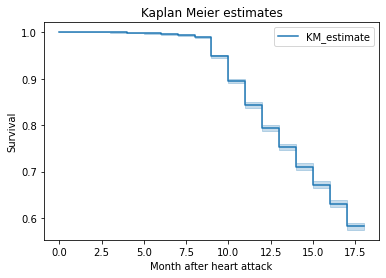

In [289]:
kmf = KaplanMeierFitter()
X= SURV[0]
Y = SURV[1]
kmf.fit(X, event_observed = Y)
kmf.plot()
plt.title("Kaplan Meier estimates")
plt.xlabel("Month after heart attack")
plt.ylabel("Survival")
plt.show()

# Tiempo de vida futuro

In [291]:
clientes_bbva= tablas[4]

In [296]:
Union_sist_fin = periodos_acc__date.merge(clientes_bbva, on=['CODIGO_CLIENTE','PERIODO'])
Union_sist_fin

,CODIGO_CLIENTE,TIPO_DOCUMENTO,PRODUCTO,NUMERO_DOCUMENTO,PERIODO,DIVISA,TIPO_MOVIMIENTO,SALDO,DIAS_ATRASO,att,SALDO_PUNTUAL,MARGEN_FINANCIERO,COMISIONES,MARGEN_BRUTO,EXPOSICION_DEFAULT,PERDIDA_ESPERADA,NUMERADOR_RATIO_RENTABILIDAD,DENOMINADOR_RATIO_RENTABILIDAD,RATIO_RENTABILIDAD
0,2726,1,CONSUMO,6153759.0,202010,1.0,10.0,3000.00,0.0,0,834.26,30.679077,0.000000,30.679077,0.0,0.0,21.628749,5.407187,4.0
1,2726,1,PEQUE�AS EMPRESAS,6153759.0,202010,1.0,10.0,37490.55,0.0,0,834.26,30.679077,0.000000,30.679077,0.0,0.0,21.628749,5.407187,4.0
2,2726,1,CONSUMO,6153759.0,202011,1.0,10.0,2778.57,0.0,0,1674.33,61.571811,0.000000,61.571811,0.0,0.0,43.408127,10.852032,4.0
3,2726,1,PEQUE�AS EMPRESAS,6153759.0,202011,1.0,10.0,34188.68,0.0,0,1674.33,61.571811,0.000000,61.571811,0.0,0.0,43.408127,10.852032,4.0
4,2726,1,CONSUMO,6153759.0,202012,1.0,10.0,2545.16,0.0,0,3134.69,115.275090,0.000000,115.275090,0.0,0.0,81.268938,20.317235,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597044,99992653,1,PEQUE�AS EMPRESAS,85392025.0,202007,1.0,10.0,58219.18,0.0,0,669.96,23.967149,64.875806,88.842955,0.0,0.0,62.634283,15.658571,4.0
597045,99992653,1,CONSUMO,85392025.0,202008,1.0,10.0,38829.78,0.0,0,3120.97,114.770551,228.183871,342.954422,0.0,0.0,241.782868,60.445717,4.0
597046,99992653,1,PEQUE�AS EMPRESAS,85392025.0,202008,1.0,10.0,101915.45,0.0,0,3120.97,114.770551,228.183871,342.954422,0.0,0.0,241.782868,60.445717,4.0
597047,99992653,1,CONSUMO,85392025.0,202009,1.0,10.0,37749.68,0.0,0,2229.92,82.003078,308.303333,390.306411,0.0,0.0,275.166020,68.791505,4.0


# Clustering

In [ ]:
def DB_plot(df__, dbs='dbs', mas_clusters = False):

  X = df__[['latitud','longitud']]

  nclustrs = 2
  ncl_kmedias = 3
  if len(X) <= 2:
    df__2 = df__.copy()
    df__2.iloc[:,2] += df__2.iloc[:,2]*.0000001
    df__ = pd.concat([df__,df__2])
    X = df__[['latitud','longitud']]
    nclustrs = 1
    
  if len(X) <= 4:
    ncl_kmedias = 1

  neigh = NearestNeighbors(nclustrs)
  
  nbrs = neigh.fit(X)
  distances, indices = nbrs.kneighbors(X)
  try:
    distances = np.sort(distances, axis=0)[:,1]
    kneedle = KneeLocator(distances, range(len(distances)), S=1.0, curve="concave", direction="increasing")
    ksff = kneedle.knee*2
  except:
    ksff = 0.01

  if ksff <= 0:
    ksff = 0.01
  # print('paso ksff')
####---Definir localización del mapa
  centro_ = centro(X)
  centros = centro_[0]
####---Definir localización del mapa
  # print('paso centro')
  if dbs == 'dbs':
    minsam = max(int(len(X)*.03),1)
    if mas_clusters:
      minsam = max(int(len(X)*.01),1)
    db = DBSCAN(eps=ksff, min_samples=minsam, metric='cityblock').fit(X)

  elif dbs == 'km':
    # print('paso km')
    for nclus in range(min(ncl_kmedias, 3), min(12, len(X))):
      db = KMeans(init="k-means++", n_clusters=nclus, n_init=4, random_state=324).fit(X)
      if (min(pd.Series(db.labels_).value_counts())<2 and ncl_kmedias > 1):
        db = KMeans(init="k-means++", n_clusters=nclus-1, n_init=4, random_state=324).fit(X)
        break
  else:
    m_samp = max(int(len(X)*.04),1)
    if mas_clusters:
      m_samp = max(int(len(X)*.02),1)
    db = OPTICS(min_samples=m_samp, xi=.05, min_cluster_size=m_samp).fit(X)
  # print(dbs)
  labels = db.labels_
  # print('paso labels')
  # Number of clusters in labels, ignoring noise if present.
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)

  X['labels'] = labels
  if n_clusters_ <= 1 and not mas_clusters and ncl_kmedias > 1:
    # Volver a hacer el ejercicio con un menor nùmero de muestras en el cluster
    print('Dpl')
    return DB_plot(df__, dbs=dbs, mas_clusters = True)
  
  lab_dic = dict()
  if n_clusters_ != 0:

    # colores = ['red', 'green', 'lightblue','purple', 'orange', 'lightgreen', 'black', 'darkgreen',
    #           'pink', 'lightred', 'beige', "cyan", "lime", "firebrick", "darkgoldenrod", "white"]
    colores = ['lightgray']*25
    i = 0
    
    for col in set(labels) - {-1}:
      lab_dic[col] = colores[i]
      i += 1
  else:
    labels = [-1]*len(db.labels_)
    n_clusters_ = 1

  lab_dic[-1] = 'gray'

  # rcParams['figure.figsize'] = (9,4)
  
  map = folium.Map(location=centros, tiles='OpenStreetMap', zoom_start=13)
  # marker_cluster = MarkerCluster().add_to(map)
  locationlist = X.values.tolist()

  leyenda_dc = X.groupby('labels').count().drop('latitud', axis = 1)
  leyenda_dc['color'] = [lab_dic[x] for x in leyenda_dc.index]
  
  df__['labels'] = labels
  df__['Competencia'] = [x if x == 'BBVA' else 'competencia' for x in df__.banco]
  compe = pd.pivot_table(df__[['Competencia','labels']].reset_index(), index = 'labels',
                         columns='Competencia',aggfunc='count').fillna(0)
  
  if len(compe.columns)==1:
    compe['BBVA'] = [0]*len(compe)
  dsa = pd.concat([leyenda_dc, compe], axis = 1)
  dsa_i = dsa.index
  dsa = dsa.values
  # print(dsa)
  rule = [akj[2]/(akj[2]+akj[3]) for akj in dsa]

  a_ = [x for _, x in sorted(zip(rule, dsa_i)) if x!=-1]
  cl_ = []
####------------Colocar ATMs en el mapa
  df__TX = [x if str(x) != 'nan' else '' for x in df__.TX]
  df__tr_real = [x if ~np.isnan(x) else 0 for x in df__.TRANSACCIONALIDAD]
  log_val = [np.log(x) if ~np.isnan(x) else 0 for x in df__.TRANSACCIONALIDAD]
  log_val_ = pd.Series(log_val)
  lgg_ln = log_val_[log_val_>0]
  if len(lgg_ln)>0:
    mrqu = np.percentile(lgg_ln,10)
  else:
    mrqu = 0

  medida = [x/mrqu+10 if x < mrqu else (x-mrqu)*2+10 for x in log_val]
  vmmax = max(medida)
  medida_col = [blue(x/vmmax) for x in medida]
  
  for point, banco, a_id, cluster, score_tx, tx_val, mmcol, NTX in zip(range(len(locationlist)), df__.banco,df__.id,
                                      labels, df__TX, medida, medida_col, df__tr_real):
    coloc_new=False

    color_1 = ''
    col_fill = 'red'#lab_dic[cluster]
    if banco == 'BBVA':
      color_1 = mmcol
      col_fill = 'grey'

    if ('BEYG' in a_id) or ('Comercial' in a_id):
      coloc_new=True
      
    if cluster != -1 and cluster not in cl_:
      X__ = X[X.labels == cluster]
      # print(len(X__))
      if len(X__) == 0:
         continue
      if len(X__) < 3:
        hull_pts = [(min(X__.latitud), max(X__.latitud), max(X__.latitud), min(X__.latitud)),
                    (min(X__.longitud), min(X__.longitud), max(X__.longitud), max(X__.longitud))]
      else:
        try:
          valores = X__[['latitud', 'longitud']].values
          hull_pts = alphashape.alphashape(valores, 0.1).exterior.coords.xy
        except:
          hull_pts = [(min(X__.latitud), max(X__.latitud), max(X__.latitud), min(X__.latitud)),
                    (min(X__.longitud), min(X__.longitud), max(X__.longitud), max(X__.longitud))]
#####----------------Visualizar bordes
      #pp = gpd.GeoDataFrame(index=[0], crs={'init': 'epsg:4326'}, geometry=[Polygon(zip(hull_pts[1], hull_pts[0]))])
      #folium.GeoJson(pp, style_function=lambda x: {'fillColor': 'darkgray', 'color': 'gray'}).add_to(map)
#####----------------Fin Visualizar bordes
    cl_.append(cluster)
    NTX = "{:,}".format(int(NTX/3))
    
    if coloc_new:
      folium.Marker(locationlist[point], popup="ATM "+banco+", " + score_tx+', '+str(NTX),
          icon=folium.Icon(color='green', icon_color='white', prefix='fa', icon="credit-card")
          ).add_to(map)
    else:
      folium.CircleMarker(
        location=locationlist[point],
        radius=tx_val,
        popup="ATM "+banco+", " + score_tx+', '+str(NTX),
        color=color_1,
        fill=True,
        fill_color=col_fill,
      ).add_to(map)
    
    
####------------Fin Colocar ATMs en el mapa
####------------Agregar Leyenda
  repre = dsa
  # print('DSA: ', dsa)
  # template = leyenda_f(dsa)
  # macro = MacroElement()
  # macro._template = Template(template)
  # map.get_root().add_child(macro)
####------------Fin Agregar Leyenda
####-----------Arreglar nombres de columnas
  nb = []
  for nombre in compe.columns:
    for a in list(nombre):
      if not (a in ['index','']):
        nb.append(a)
  compe.columns = nb
  
  leyenda_dc.columns = ['atms_t',	'color']
####-----------Fin Arreglar nombres de columnas

  aa = pd.concat([leyenda_dc,compe],axis = 1)
  # return(df__, a_, aa, leyenda_dc,compe)
  df__= df__.merge(aa.reset_index(),on = 'labels')

  return map, df__, a_, centros, repre
